In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [2]:
# graph22 imports
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [3]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
physical_device = tf.config.experimental.list_physical_devices('GPU')
print(f'Device found : {physical_device}')

Device found : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
#check if GPU is used as compute-unit as default
print(tf.config.experimental.get_memory_growth(physical_device[0]))

None


In [6]:
#as NONE means it's not now setting
tf.config.experimental.set_memory_growth(physical_device[0],True)

In [7]:
print(tf.config.experimental.get_memory_growth(physical_device[0]))

True


In [8]:
df = pd.read_csv('GOOG-new.csv')
df.head(254)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-09-01,51.158245,51.292744,49.648903,49.937820,49.937820,9181687
1,2004-09-02,49.409801,50.993862,49.285267,50.565468,50.565468,15190525
2,2004-09-03,50.286514,50.680038,49.474556,49.818268,49.818268,5176932
3,2004-09-07,50.316402,50.809551,49.619015,50.600338,50.600338,5875340
4,2004-09-08,50.181908,51.322632,50.062355,50.958992,50.958992,5009306
...,...,...,...,...,...,...,...
249,2005-08-26,141.210709,141.977829,140.802246,141.260529,141.260529,7538752
250,2005-08-29,140.593018,144.020172,140.593018,143.686432,143.686432,11850252
251,2005-08-30,143.158401,144.214447,142.406219,143.098633,143.098633,9619923
252,2005-08-31,143.576843,143.711334,141.649063,142.466003,142.466003,10105737


In [9]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.000106
1,0.000664
2,0.000000
3,0.000695
4,0.001013


In [10]:
simulation_size = 10
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 50
dropout_rate = 0.8
test_size = 80
learning_rate = 0.001

In [11]:
df_train = df_log
df.shape, df_train.shape

((3482, 7), (3482, 1))

In [12]:

class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.compat.v1.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.compat.v1.placeholder(tf.float32, (None, None, size))
        self.Y = tf.compat.v1.placeholder(tf.float32, (None, output_size))
        drop = tf.compat.v1.nn.rnn_cell.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.compat.v1.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.compat.v1.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.compat.v1.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(input_tensor=tf.square(self.Y - self.logits))
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer


In [13]:
from tensorflow.python.framework import ops

In [14]:
def forecast():
    ops.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.compat.v1.InteractiveSession()
    sess.run(tf.compat.v1.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.4)
    
    return deep_future

In [15]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


train loop: 100%|██████████| 50/50 [02:55<00:00,  3.50s/it, acc=98.6, cost=0.00048] 


simulation 2


train loop: 100%|██████████| 50/50 [02:55<00:00,  3.51s/it, acc=98.7, cost=0.000435]


simulation 3


train loop: 100%|██████████| 50/50 [02:56<00:00,  3.52s/it, acc=98.8, cost=0.000424]


simulation 4


train loop: 100%|██████████| 50/50 [02:55<00:00,  3.51s/it, acc=98.6, cost=0.000501]


simulation 5


train loop: 100%|██████████| 50/50 [02:55<00:00,  3.51s/it, acc=98.6, cost=0.000544]


simulation 6


train loop: 100%|██████████| 50/50 [02:55<00:00,  3.50s/it, acc=98.7, cost=0.000472]


simulation 7


train loop: 100%|██████████| 50/50 [02:53<00:00,  3.47s/it, acc=98.7, cost=0.000442]


simulation 8


train loop: 100%|██████████| 50/50 [02:55<00:00,  3.50s/it, acc=98.7, cost=0.000444]


simulation 9


train loop: 100%|██████████| 50/50 [02:56<00:00,  3.52s/it, acc=98.6, cost=0.000562]


simulation 10


train loop: 100%|██████████| 50/50 [02:55<00:00,  3.51s/it, acc=98.6, cost=0.000516]


In [20]:
accepted_results = []
for r in results:
    if (np.array(r[-test_size:]) < np.min(df['Close'])).sum() == 0 and \
    (np.array(r[-test_size:]) > np.max(df['Close']) * 2).sum() == 0:
        accepted_results.append(r)
len(accepted_results)

10

In [21]:
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
for i in range(test_size):
    date_ori.append(date_ori[-1] + timedelta(days = 1))
date_ori = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d').tolist()
date_ori[-5:]

['2018-08-24', '2018-08-25', '2018-08-26', '2018-08-27', '2018-08-28']

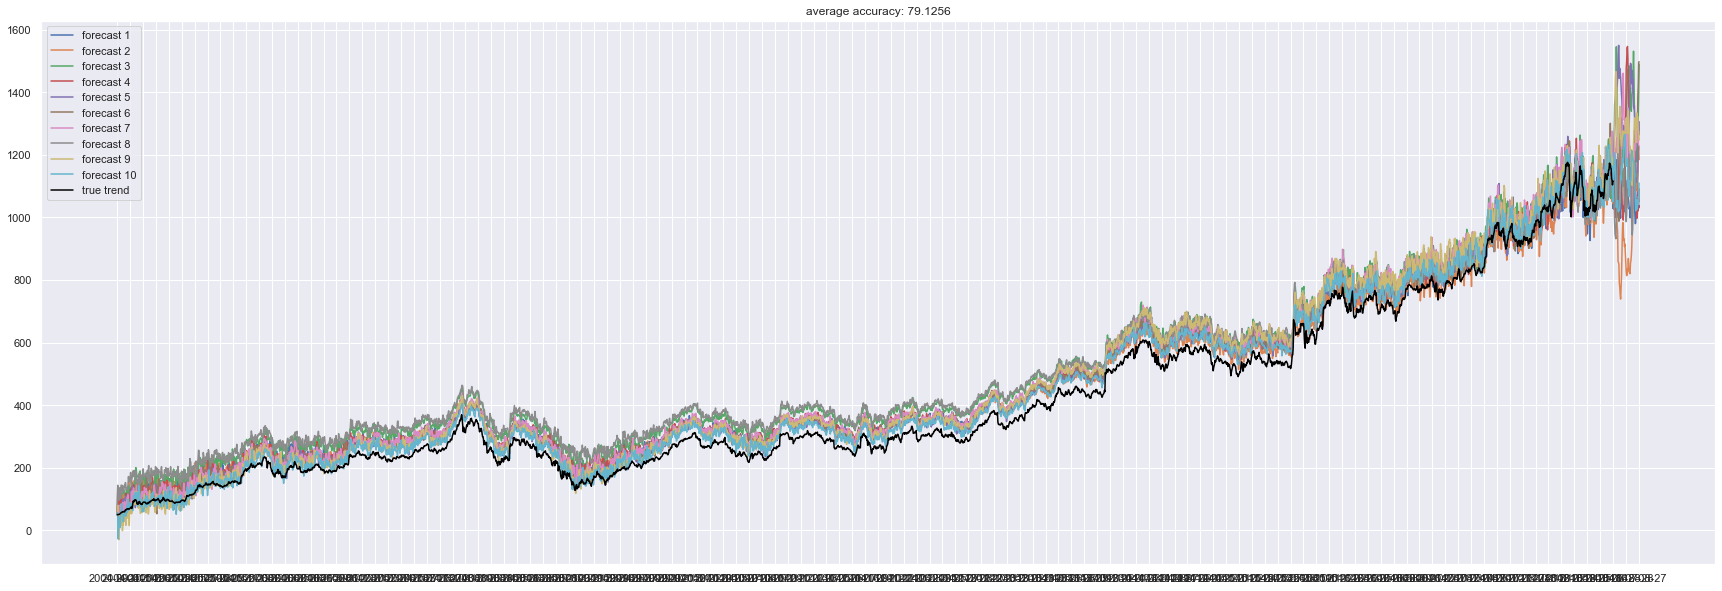

In [22]:
accuracies = [calculate_accuracy(df['Close'].values, r[:-test_size]) for r in accepted_results]

plt.figure(figsize = (30, 10))
for no, r in enumerate(accepted_results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['Close'], label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))

x_range_future = np.arange(len(results[0]))
plt.xticks(x_range_future[::30], date_ori[::30])

plt.show()

In [1]:
fig = make_subplots()
trace1 = go.Scatter(y=df['Close'],x=df['Date'], mode='lines',line=dict(color='black'))

for no, r in enumerate(accepted_results): 
 fig.add_trace(go.Scatter(y=accepted_results[no],x=date_ori[:4500]))
fig.add_trace(trace1)    
fig.show()   

NameError: name 'make_subplots' is not defined